# Final Project
## What makes a college player successful in the NBA

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### Import first dataset

In [2]:
#Dataset with Player name, year, and draft pick
df_draft = pd.read_csv('/Users/dempseywade/Desktop/gitRepo/NBADraftFinalProject/data/NBA_Full_Draft_1947-2018.csv')

#Drop unnecessary datasets
df_draft = df_draft.drop(['Unnamed: 0', 'Play_Yrs','College',
                          'Games','Team'], axis = 1)

#Filter old players
df_draft = df_draft[df_draft.Year >=2012]

#Change type
df_draft.Player = df_draft.Player.astype('string')

#Visualize the dataset
df_draft.head(10)

Player  Year  Pick
7543           Anthony Davis  2012     1
7544  Michael Kidd-Gilchrist  2012     2
7545            Bradley Beal  2012     3
7546            Dion Waiters  2012     4
7547         Thomas Robinson  2012     5
7548          Damian Lillard  2012     6
7549         Harrison Barnes  2012     7
7550           Terrence Ross  2012     8
7551          Andre Drummond  2012     9
7552           Austin Rivers  2012    10

In [3]:
#Some basic EDA
df_draft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 7543 to 7962
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Player  420 non-null    string
 1   Year    420 non-null    int64 
 2   Pick    420 non-null    int64 
dtypes: int64(2), string(1)
memory usage: 13.1 KB


In [4]:
#Will graph in the next cell, but want to ensure that we have 60 in each year
df_draft.Year.value_counts()

2012    60
2013    60
2014    60
2015    60
2016    60
2017    60
2018    60
Name: Year, dtype: int64

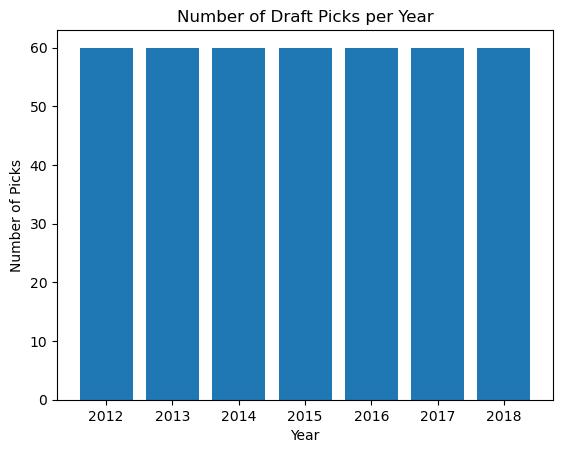

In [5]:
#Let's visualize our df for others like me who enjoy seeing confirmation

#Graph that's based on number of picks per year
#    As printed above, each year should have 60 values
#    30 in the first round and 30 in the second

plt.bar('Year','Pick', data = df_draft)
plt.xlabel('Year')
plt.ylabel('Number of Picks')
plt.title('Number of Draft Picks per Year')
plt.show()

In [6]:
#Lastly, just to be even *more* cautious, 
#    lets count the quantity of each pick number
#For large datasets, something similiar will have to be done 
#    since it isn't always feasible to look through all the data 
#Avoid Garbage In, Garbage Out!!!

#Just the first round and just the second round picks...
df_fr = df_draft[df_draft.Pick > 30]
df_sr = df_draft[df_draft.Pick <= 30]

#Then we get our years
year_value_counts = df_draft.Year.value_counts()
years = year_value_counts[:].index

#The years we are working with
print(years)

Int64Index([2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype='int64')


In [7]:
print('Number of first round picks by Year, followed by the ')
print('number of second round picks. We are expecting two ')
print('values of \'30\' with a comma inbetween for each year.')

#for each year, print the number of first and second round picks
for i in years:
    print(i,':', df_fr['Year'].value_counts()[i],',',df_sr['Year'].value_counts()[i])

Number of first round picks by Year, followed by the 
number of second round picks. We are expecting two 
values of '30' with a comma inbetween for each year.
2012 : 30 , 30
2013 : 30 , 30
2014 : 30 , 30
2015 : 30 , 30
2016 : 30 , 30
2017 : 30 , 30
2018 : 30 , 30


In [8]:
# Perfect! Appears to be a complete data set. No worries. 
# If we still weren't sure, we could check each pick value. 
# And it would look like:

sort_picks = df_draft.sort_values(by=['Pick'], ascending = False)
pick_counts = sort_picks.Pick.value_counts()

#Lowest and highest should be the same, both 7
print(pick_counts.max())
print(pick_counts.min())

#We should see 7 values for each of the 60 picks
pick_counts.value_counts()

7
7


7    60
Name: Pick, dtype: int64

In [9]:
#All set. Onto the next dataset

## Add our second dataset
### With college player career data

In [10]:
#Dataset with Player name, year, and draft pick
df_players = pd.read_csv('/Users/dempseywade/Desktop/gitRepo/NBADraftFinalProject/data/players.csv')

#Drop unnecessary columns
df_players = df_players.drop(['birthDate', 'birthPlace',
                             'highSchool','position','shoots',
                              'weight', 'height', 'college',
                             'draft_pick','draft_round','draft_team'], axis = 1)
#It may seem redundant to drop 'draft_pick' but the format is simplist 

#Rename name to Player for uniformity through datasets
df_players = df_players.rename(columns={'name':'Player', '_id':'player_id'})

#Reorder columns
cols = list(df_players.columns.values) 
cols.pop(cols.index('Player')) 
df_players = df_players[['Player']+cols]

#Filter old players
df_players = df_players.dropna()
df_players.draft_year = df_players.draft_year.astype('int')
df_players = df_players[df_players.draft_year >=2012]

df_players.head(10)

Player  player_id  career_AST career_FG% career_FG3% career_FT%  \
9      Alex Abrines  abrinal01         0.5       38.7        36.8       88.0   
14       Quincy Acy    acyqu01         0.6       44.4        35.0       75.9   
20     Jordan Adams  adamsjo01         0.6       40.2        38.5       60.7   
22     Steven Adams  adamsst01         1.0       58.8         0.0       55.3   
24      Bam Adebayo  adebaba01         1.9       55.0        13.6       72.8   
41   Furkan Aldemir  aldemfu01         0.7       51.3         0.0       48.1   
55    Grayson Allen  allengr01         0.7       37.6        32.3       75.0   
56    Jarrett Allen  allenja01         1.0       59.0        18.3       73.2   
58     Kadeem Allen  allenka01         2.4       43.6        36.2       77.8   
93  Justin Anderson  anderju01         0.7       41.9        30.2       77.8   

    career_G career_PER  career_PTS career_TRB career_WS career_eFG%  \
9        174        8.8         5.3        1.4       5.0        52.5   
14       337       11.2         4.9        3.5       8.7        51.3   
20        32       13.1         3.2        0.9       0.4        45.7   
22       467       16.7         9.7        7.4      38.7        58.8   
24       151       17.0         8.0        6.5      11.0        55.1   
41        41       12.0         2.3        4.3       1.4        51.3   
55        38        7.5         5.6        0.6       0.0        46.6   
56       152       18.1         9.6        7.0      11.9        59.5   
58        37       13.4         5.6        1.7       0.9        48.8   
93       216       12.9         5.3        2.6       4.7        49.0   

    draft_year  
9         2013  
14        2012  
20        2014  
22        2013  
24        2017  
41        2012  
55        2018  
56        2017  
58        2017  
93        2015

In [11]:
#Sort by career PTS
# make it easier to read by putting 'career_PTS' in the third column
c_pts = df_players.pop('career_PTS')
df_players.insert(2, 'career_PTS', c_pts)

# then print the top 5 for a quick check 
df_players.sort_values(by=['career_PTS'], ascending = False).head(5)

Player  player_id  career_PTS  career_AST career_FG%  \
1197         Joel Embiid  embiijo01        24.3         3.2       48.1   
932        Anthony Davis  davisan02        23.7         2.1       51.7   
2485      Damian Lillard  lillada01        23.5         6.3       43.4   
4173  Karl-Anthony Towns  townska01        22.3         2.6       53.7   
2869    Donovan Mitchell  mitchdo01        22.1         3.9       43.4   

     career_FG3% career_FT%  career_G career_PER career_TRB career_WS  \
1197        31.5       78.8       158       24.5       11.4      16.8   
932         31.4       79.5       466       27.4       10.5      72.0   
2485        36.8       88.9       549       21.4        4.2      70.3   
4173        39.2       83.6       323       25.0       11.9      45.4   
2869        35.1       80.5       156       16.9        3.9      10.2   

     career_eFG%  draft_year  
1197        51.4        2014  
932         52.8        2012  
2485        51.0        2012  
4173        57.5        2015  
2869        49.9        2017

In [12]:
#Quick sanity check...

In [13]:
#Combine the two datasets
#we want the new dataset to be less than the length as df_draft
#since some players did not join their teams ever
print('Previous Length:', len(df_draft))

df_nba = pd.merge(df_draft, df_players, on='Player', how='inner')

print('Current Length:', len(df_nba))

df_nba.head(10)

Previous Length: 420
Current Length: 349


Player  Year  Pick  player_id  career_PTS  career_AST  \
0           Anthony Davis  2012     1  davisan02        23.7         2.1   
1  Michael Kidd-Gilchrist  2012     2  kiddgmi01         8.8         1.2   
2            Bradley Beal  2012     3   bealbr01        19.8         3.7   
3            Dion Waiters  2012     4  waitedi01        13.2         2.8   
4         Thomas Robinson  2012     5  robinth01         4.9         0.6   
5          Damian Lillard  2012     6  lillada01        23.5         6.3   
6         Harrison Barnes  2012     7  barneha02        13.6         1.5   
7           Terrence Ross  2012     8   rosste01        10.5         1.1   
8          Andre Drummond  2012     9  drumman01        14.1         1.2   
9           Austin Rivers  2012    10  riverau01         9.2         2.4   

  career_FG% career_FG3% career_FT%  career_G career_PER career_TRB career_WS  \
0       51.7        31.4       79.5       466       27.4       10.5      72.0   
1       47.7        27.7       71.4       421       13.7        5.6      21.2   
2       45.2        38.4       79.8       488       17.1        3.9      36.4   
3       41.2        34.7       69.2       409       12.0        2.7       8.7   
4       47.0         0.0       50.5       313       14.0        4.8       4.6   
5       43.4        36.8       88.9       549       21.4        4.2      70.3   
6       44.6        37.4       79.5       540       13.3        4.9      29.7   
7       42.3        37.4       81.9       492       12.6        2.8      19.2   
8       54.3        14.7       44.8       542       22.1       13.7      56.4   
9       41.7        34.7       63.7       484       10.2        2.0       9.1   

  career_eFG%  draft_year  
0        52.8        2012  
1        48.1        2012  
2        51.9        2012  
3        46.8        2012  
4        47.0        2012  
5        51.0        2012  
6        50.0        2012  
7        52.1        2012  
8        54.4        2012  
9        48.2        2012

In [14]:
df_chart = df_nba[['Player','Pick','career_AST','career_PER','career_PTS','career_TRB']]
df_chart.head(10)

Player  Pick  career_AST career_PER  career_PTS career_TRB
0           Anthony Davis     1         2.1       27.4        23.7       10.5
1  Michael Kidd-Gilchrist     2         1.2       13.7         8.8        5.6
2            Bradley Beal     3         3.7       17.1        19.8        3.9
3            Dion Waiters     4         2.8       12.0        13.2        2.7
4         Thomas Robinson     5         0.6       14.0         4.9        4.8
5          Damian Lillard     6         6.3       21.4        23.5        4.2
6         Harrison Barnes     7         1.5       13.3        13.6        4.9
7           Terrence Ross     8         1.1       12.6        10.5        2.8
8          Andre Drummond     9         1.2       22.1        14.1       13.7
9           Austin Rivers    10         2.4       10.2         9.2        2.0

In [15]:
#Convert rebounds to correct types to view correlation
df_chart['career_TRB'] = df_chart['career_TRB'].astype('float')
df_chart['career_PER'] = df_chart['career_PER'].astype('float')

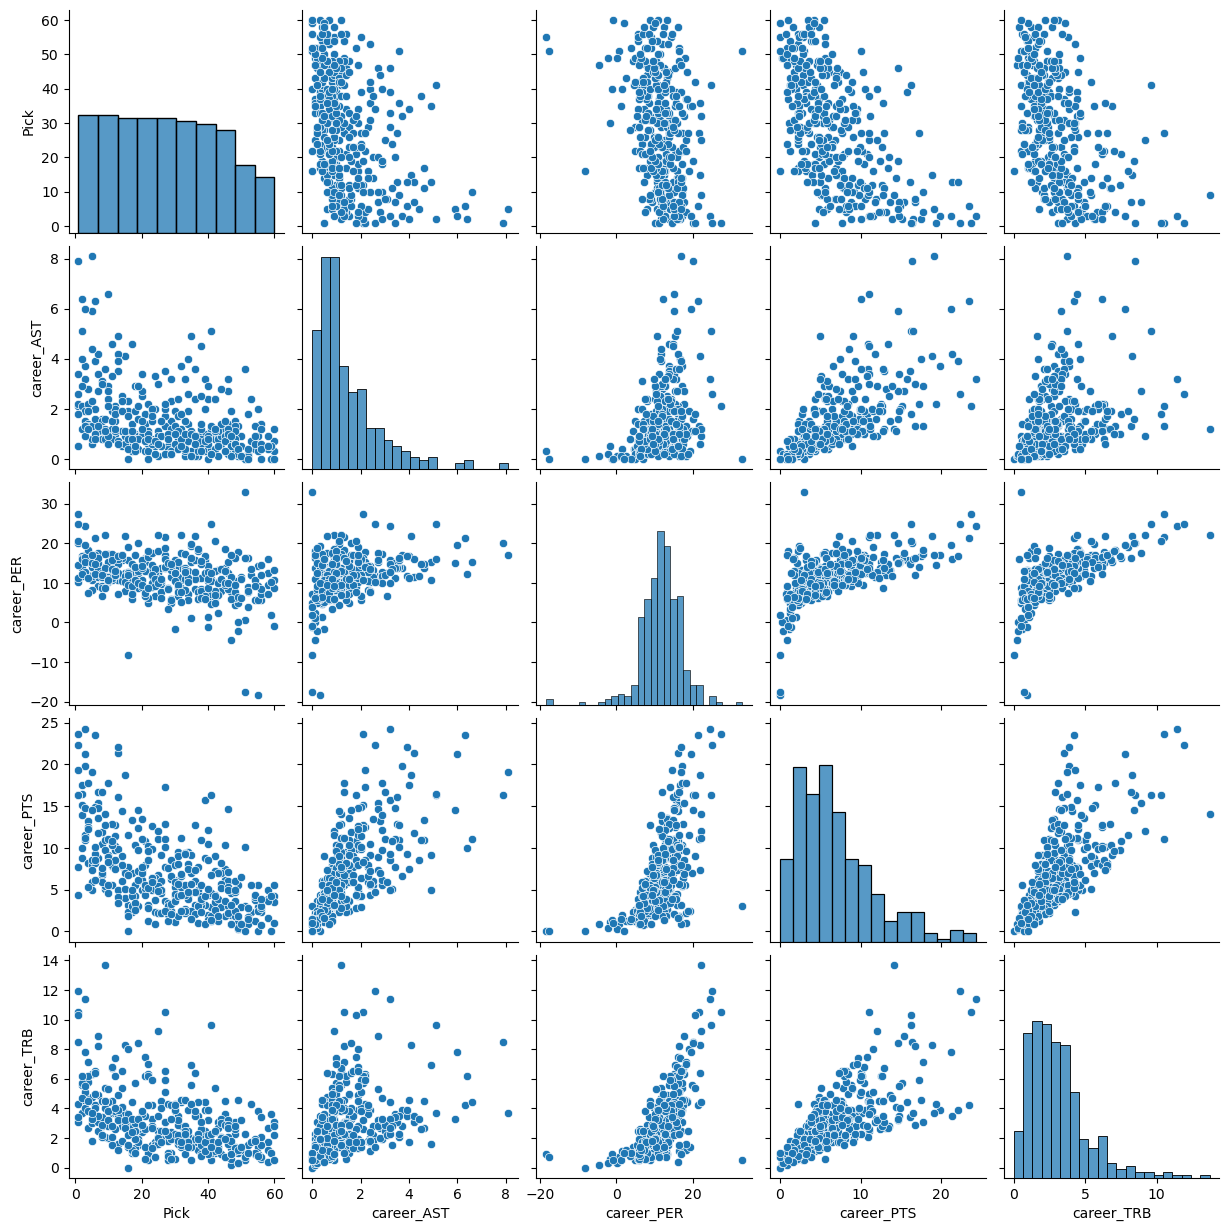

In [16]:
# Chart to view correlation between a few variables
# Will convert types and view all variables in df_nba later
sns.pairplot(df_chart)

If we look at the top row of graphs, where pick is compared to career assists per game and points per game, it's not surprising to observe that the closer you are to y = 0 (proximity to #1 overall pick), the higher your 'value' will be. Meaning, the closer you were to the number 1 pick for that year, the higher your points and rebounds tended to be for your career. 

We can see lots of clustering data points, forming a cone-like shape. This makes logical sense as typically it is the lottery draft picks who seperate themselves from the rookie class and have outlier type stats. 

It is important to note that we can see outliers with a low draft position as well.


<b> Let's take a closer look at 'Pick' compared to 'career_PTS': </b>

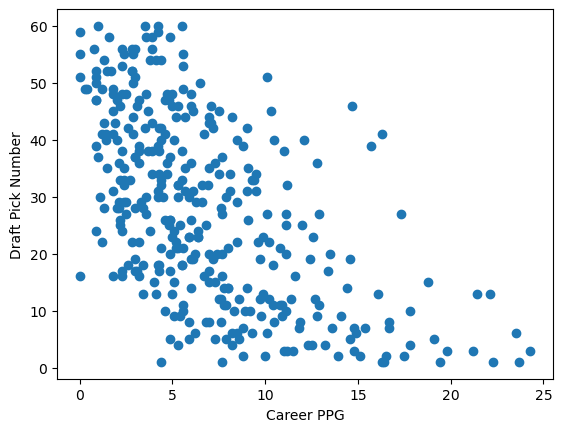

In [17]:
plt.scatter(y = df_nba['Pick'], x = df_nba['career_PTS'])
plt.xlabel('Career PPG')
plt.ylabel('Draft Pick Number')
plt.show()

Lots of points to the left of x = 10 on the graph, makes sense due to the number of 10PPG scorers in the NBA. 
What also makes sense is the diagnal clustering occuring. We can see a fairly distinct line form that displays a correlation between draft picks position and PPG production. The closer a player is to to the #1 overall, the more PPG they produced, on average. 

We do have to keep in mind, legends like Mr. 305 Udonis Haslem, won't show up on studies like this one because he went undrafted. Lots of data to perform further analysis on this topic in the future.

In [18]:
#Now incorporate salary so we have a target variable
df_salary = pd.read_csv('/Users/dempseywade/Desktop/gitRepo/NBADraftFinalProject/Data/salaries_1985to2018.csv')

#Drop unnecessary
df_salary = df_salary.drop(['season_end','season_start'], axis = 1)

#Get mean salary for each player
df_salary = df_salary.groupby(['player_id']).mean()
df_salary = df_salary.astype('int')

df_salary.head(10)

salary
player_id         
abdelal01   568800
abdulka01  2140000
abdulma02  2205500
abdulta01  3798280
abdursh01  8715090
abrinal01  5859882
ackeral01   649829
acresma01   321800
acyqu01    1146500
adamsal01   591666

In [19]:
#Use player id to merge dataframes
df_nba = pd.merge(df_salary, df_nba, on='player_id', how='inner')
df_nba.head(10)

player_id   salary           Player  Year  Pick  career_PTS  career_AST  \
0  abrinal01  5859882     Alex Abrines  2013    32         5.3         0.5   
1    acyqu01  1146500       Quincy Acy  2012    37         4.9         0.6   
2  adamsjo01  1404600     Jordan Adams  2014    22         3.2         0.6   
3  adamsst01  6433461     Steven Adams  2013    12         9.7         1.0   
4  adebaba01  2490360      Bam Adebayo  2017    14         8.0         1.9   
5  aldemfu01  3000000   Furkan Aldemir  2012    53         2.3         0.7   
6  allenja01  1713720    Jarrett Allen  2017    22         9.6         1.0   
7  anderju01  1514200  Justin Anderson  2015    21         5.3         0.7   
8  anderky01  1395085    Kyle Anderson  2014    30         5.3         1.9   
9  anigbik01   950000     Ike Anigbogu  2017    47         0.9         0.1   

  career_FG% career_FG3% career_FT%  career_G career_PER career_TRB career_WS  \
0       38.7        36.8       88.0       174        8.8        1.4       5.0   
1       44.4        35.0       75.9       337       11.2        3.5       8.7   
2       40.2        38.5       60.7        32       13.1        0.9       0.4   
3       58.8         0.0       55.3       467       16.7        7.4      38.7   
4       55.0        13.6       72.8       151       17.0        6.5      11.0   
5       51.3         0.0       48.1        41       12.0        4.3       1.4   
6       59.0        18.3       73.2       152       18.1        7.0      11.9   
7       41.9        30.2       77.8       216       12.9        2.6       4.7   
8       49.2        32.4       70.6       300       13.5        3.9      15.4   
9       33.3           -       83.3        14       17.0        0.9       0.0   

  career_eFG%  draft_year  
0        52.5        2013  
1        51.3        2012  
2        45.7        2014  
3        58.8        2013  
4        55.1        2017  
5        51.3        2012  
6        59.5        2017  
7        49.0        2015  
8        51.4        2014  
9        33.3        2017

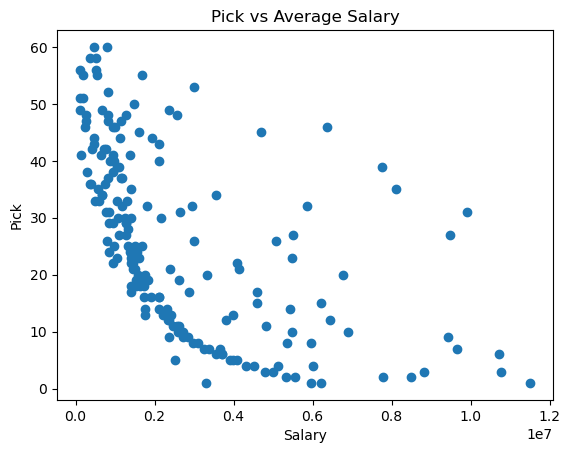

In [20]:
#Scatter plot of Pick vs Average Salary
df_nba2Contract = df_nba[df_nba['Year'] <=2015]
plt.scatter('salary', 'Pick', data = df_nba2Contract)
plt.ylabel('Pick')
plt.xlabel('Salary')
plt.title('Pick vs Average Salary')
plt.show()

<b> GARBAGE IN GARBAGE OUT ALERT </b>
Not all draft picks sign the same length contract. If this graph was simply the contract you signed on draft night, it would be worthless data. Just repeat information to ruin our algorithm and analysis. 
I filtered players out that were drafted *after* 2015, in an attempt to remove players still on their rookie deals. Without checking each player's contract length, waiver history, etc. this will do as a rough approximation. 
I will observe the graph, but not draw any definitives conclusions from this graph for those reasons. 

This is the chart that we would expect, with a fairly definitive curve between a high draft pick ranking and a high salary, with outliers. We will now look for and find other variables that contribute to a high salary, without including their draft pick. 

### Create a new varible: TotalPRA
It might be more predictive to see the total points, rebounds, and assists a college player has contributed. Along with making bins for salary, TotalPRA will allow us to try clustering and determine if an "all around" player (one with a high total of points,rebounds, and assists) is more valuable than one that is good at only one or two of these catagories.

In my exploratory efforts, I noticed low confidence because some PG's (high AST and low REB) got large salaries and some C's (high REB and low AST) as well, which made it difficult for my algorithm to make a definitive conclusion.

Hence, a new variable that has performed the best in my research, a combination of the triple-double stats. 

In [21]:
#Make a new column for Total Points, Rebounds, Assists
columns_to_sum = list(df_nba[['career_AST', 'career_PTS','career_TRB']])
df_nba['TotalPRA'] = df_nba[columns_to_sum].sum(axis = 1)
df_nba.head(5)

player_id   salary        Player  Year  Pick  career_PTS  career_AST  \
0  abrinal01  5859882  Alex Abrines  2013    32         5.3         0.5   
1    acyqu01  1146500    Quincy Acy  2012    37         4.9         0.6   
2  adamsjo01  1404600  Jordan Adams  2014    22         3.2         0.6   
3  adamsst01  6433461  Steven Adams  2013    12         9.7         1.0   
4  adebaba01  2490360   Bam Adebayo  2017    14         8.0         1.9   

  career_FG% career_FG3% career_FT%  career_G career_PER career_TRB career_WS  \
0       38.7        36.8       88.0       174        8.8        1.4       5.0   
1       44.4        35.0       75.9       337       11.2        3.5       8.7   
2       40.2        38.5       60.7        32       13.1        0.9       0.4   
3       58.8         0.0       55.3       467       16.7        7.4      38.7   
4       55.0        13.6       72.8       151       17.0        6.5      11.0   

  career_eFG%  draft_year  TotalPRA  
0        52.5        2013       5.8  
1        51.3        2012       5.5  
2        45.7        2014       3.8  
3        58.8        2013      10.7  
4        55.1        2017       9.9

In [22]:
#View data types to change in next cell 
df_nba.dtypes

player_id       object
salary           int64
Player          object
Year             int64
Pick             int64
career_PTS     float64
career_AST     float64
career_FG%      object
career_FG3%     object
career_FT%      object
career_G         int64
career_PER      object
career_TRB      object
career_WS       object
career_eFG%     object
draft_year       int64
TotalPRA       float64
dtype: object

In [23]:
#Convert to correct types
df_nba = df_nba.dropna()
df_nba = df_nba.replace('-', 0)
df_nba['Player'] = df_nba['Player'].astype('string')
df_nba['career_AST'] = df_nba['career_AST'].astype('float')
df_nba['career_FG%'] = df_nba['career_FG%'].astype('float')
df_nba['career_FG3%'] = df_nba['career_FG3%'].astype('float')
df_nba['career_FT%'] = df_nba['career_FT%'].astype('float')
df_nba['career_PER'] = df_nba['career_PER'].astype('float')
df_nba['career_FT%'] = df_nba['career_FT%'].astype('float')
df_nba['career_TRB'] = df_nba['career_TRB'].astype('float')
df_nba['career_WS'] = df_nba['career_WS'].astype('float')
df_nba['career_eFG%'] = df_nba['career_eFG%'].astype('float')

df_nba.dtypes

player_id       object
salary           int64
Player          string
Year             int64
Pick             int64
career_PTS     float64
career_AST     float64
career_FG%     float64
career_FG3%    float64
career_FT%     float64
career_G         int64
career_PER     float64
career_TRB     float64
career_WS      float64
career_eFG%    float64
draft_year       int64
TotalPRA       float64
dtype: object

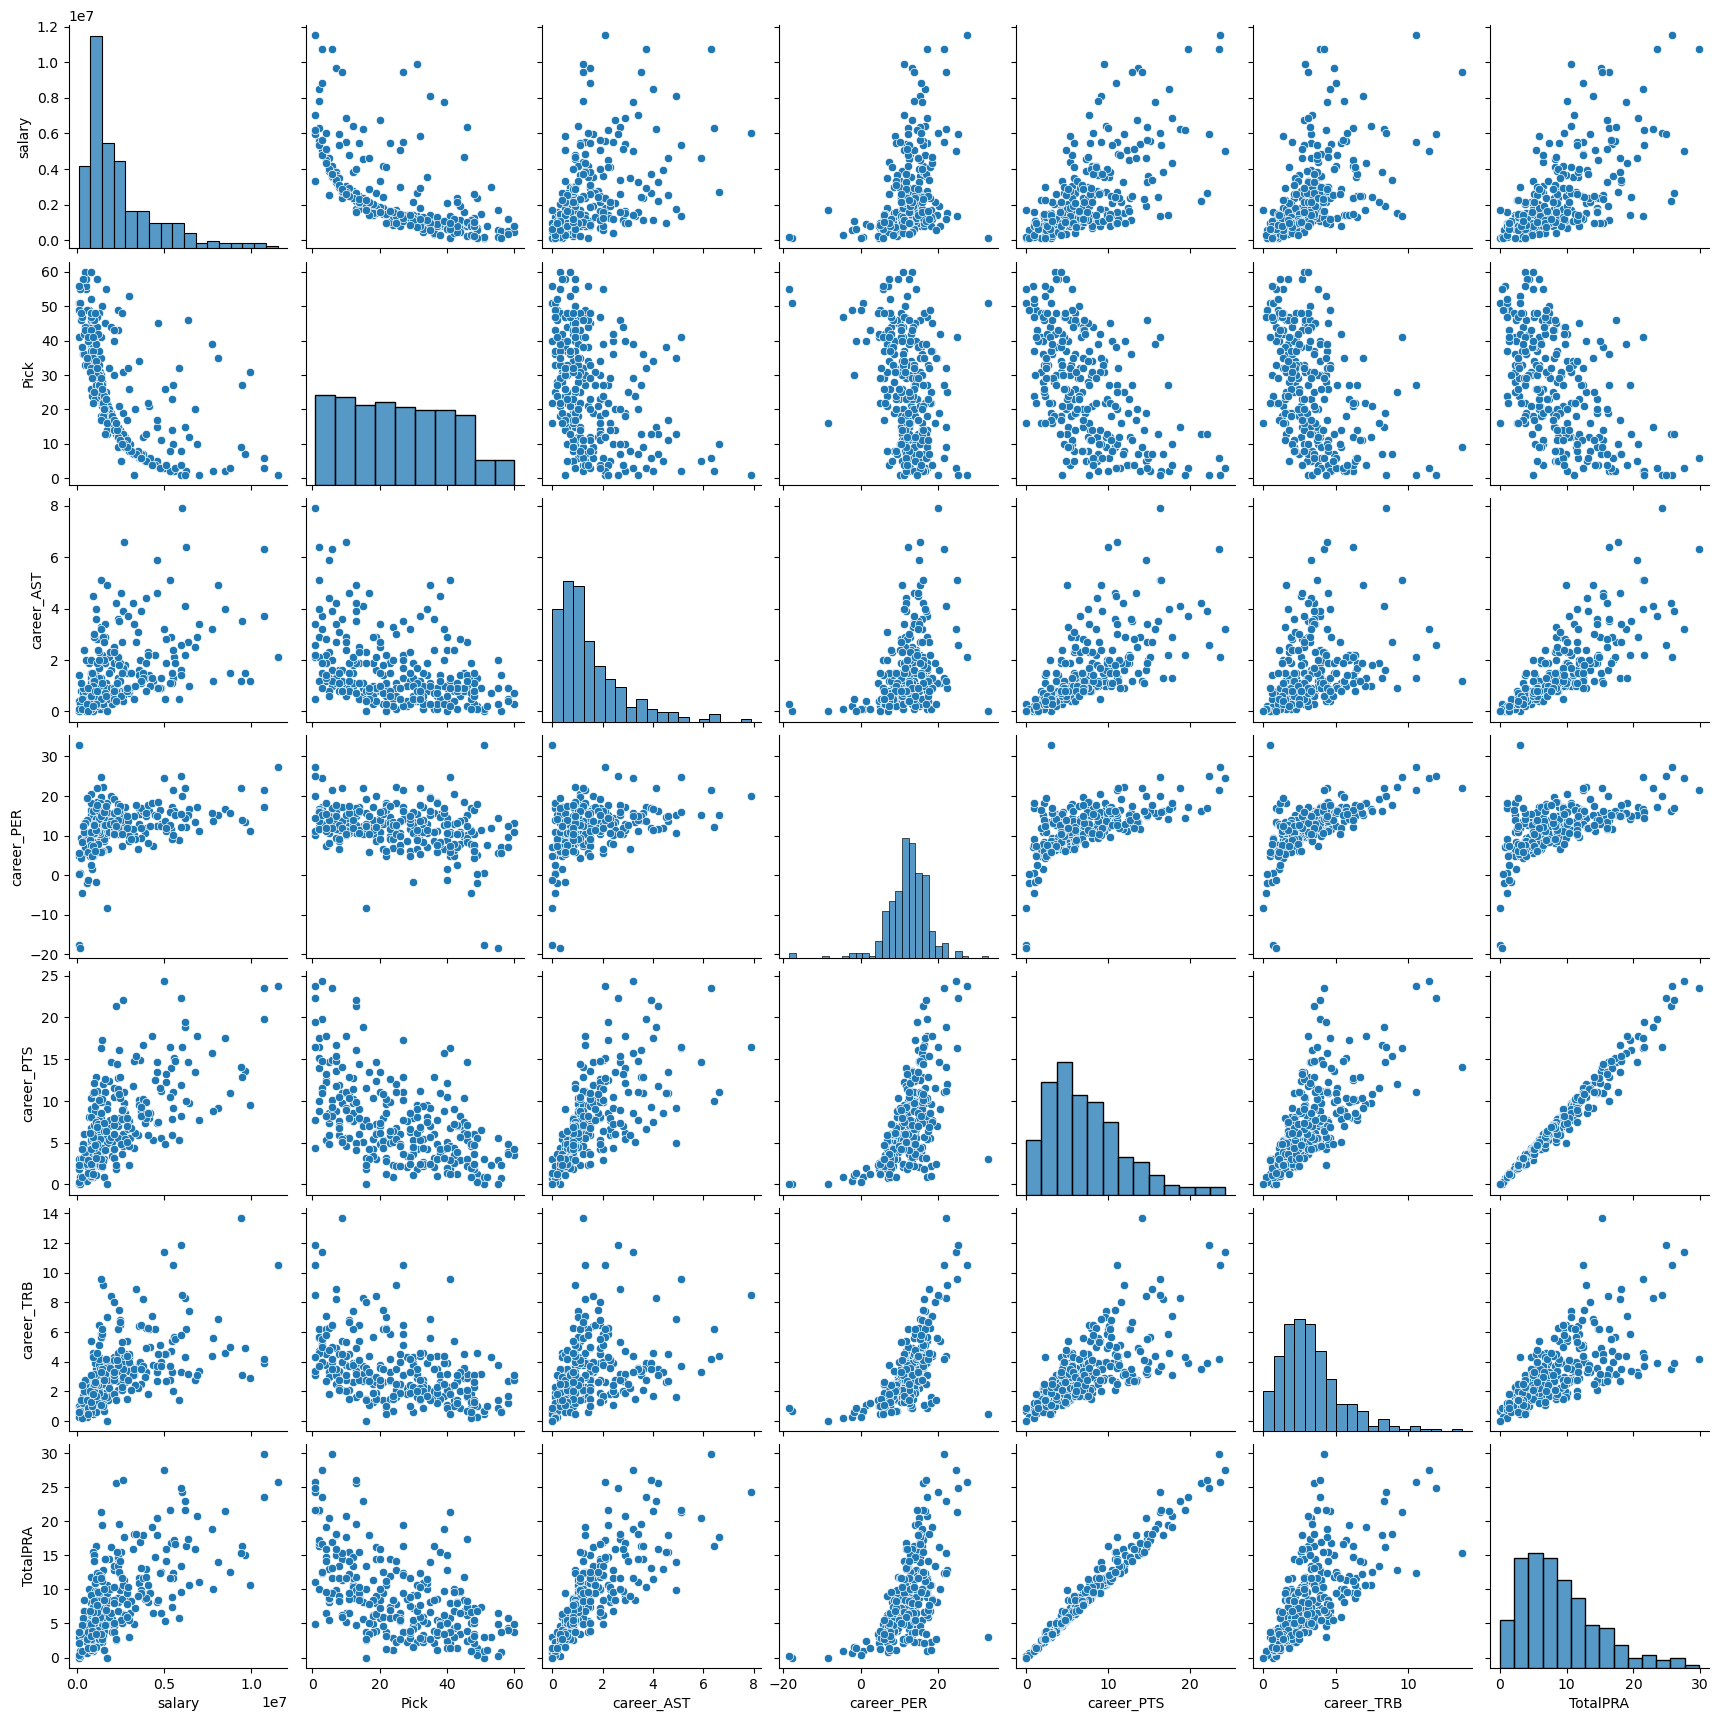

In [24]:
#Rechart now that variables are of correct type
df_chart = df_nba[['salary','Pick','career_AST','career_PER',
                   'career_PTS','career_TRB','TotalPRA']]
sns.pairplot(df_chart)

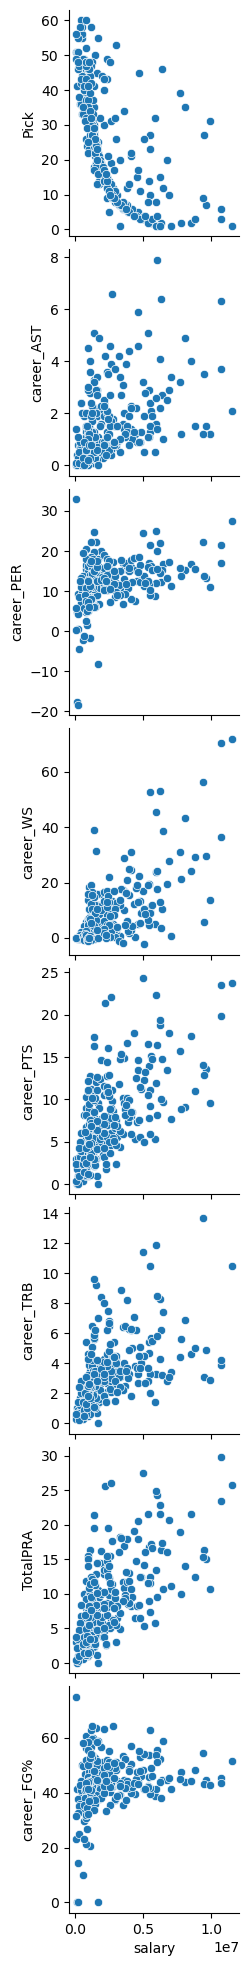

In [25]:
df_chart = df_nba[['salary','Pick','career_AST','career_PER',
                   'career_PTS','career_TRB','TotalPRA',
                  'career_WS', 'career_FG%']]

sns.pairplot(data=df_chart,
                  x_vars=['salary'],
                  y_vars=['Pick','career_AST','career_PER','career_WS',
                   'career_PTS','career_TRB','TotalPRA','career_FG%' ])

## Clustering based on salary

In [26]:
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure, adjusted_rand_score

In [27]:
X = df_nba[['TotalPRA', 'salary']]

results = pd.DataFrame({1:[1, 1]})
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i).fit(X)
    sse = kmeans.inertia_
    sil = silhouette_score(X, kmeans.fit_predict(X))
    temp = pd.DataFrame({i:[sse, sil]})
    results = results.join(temp)

results = results.drop(results.columns[0], axis = 1)
results = results.T
results = results.rename(columns = {0:'SSE',1:'Silhouette'})
results

SSE  Silhouette
2   3.828340e+14    0.704785
3   1.932548e+14    0.683763
4   9.639867e+13    0.624929
5   6.654123e+13    0.547897
6   4.689687e+13    0.564004
7   3.443383e+13    0.561003
8   2.635463e+13    0.560442
9   2.173767e+13    0.568761
10  1.719080e+13    0.561556

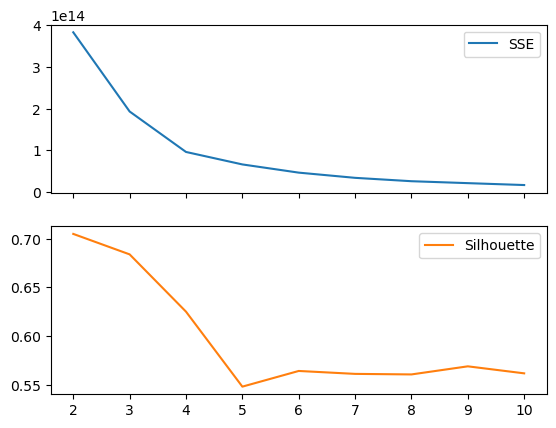

In [28]:
#Plot the above dataframe
axes = results.plot.line(subplots=True)

From the above graphs, we can see an approximate number of clusters could be 4, so lets see what 4 clusters look like:

In [29]:
#To save our image and write it further at the end
import pickle

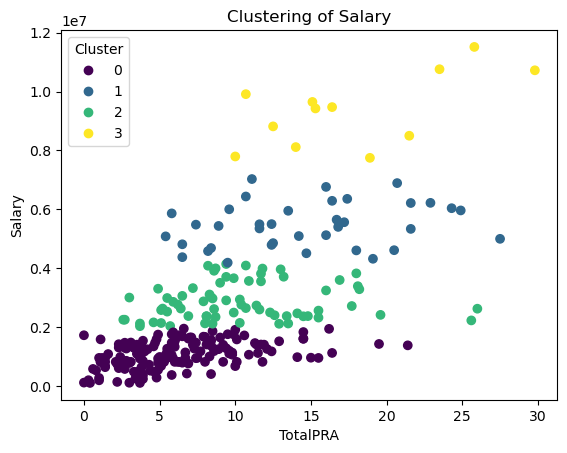

In [30]:
kmeans = KMeans(n_clusters = 4).fit(X)
labels = kmeans.fit_predict(X)

#Recategorize labels so they are in increasing order
labels2 = pd.DataFrame(labels.copy())
#labels2 = labels2.replace([0,1,2,3,4], [4,0,1,3,2])

X['Labels'] = labels2

gif, ax = plt.subplots()

scatter = plt.scatter(X['TotalPRA'], X['salary'], c = X['Labels'], label = labels2)
legend = ax.legend(*scatter.legend_elements(), title='Cluster')

plt.xlabel('TotalPRA')
plt.ylabel('Salary')
plt.title('Clustering of Salary')

pickle.dump(ax, open('cluster.pickle', 'wb'))

In [31]:
df_nba['Cluster_labels'] = labels2

#Maximum value in each cluster label
df_nba.groupby(['Cluster_labels'], sort=False)['salary'].max()

Cluster_labels
1     7026240
0     1944863
2     4140340
3    11515044
Name: salary, dtype: int64

In [32]:
#minimum value in each cluster label
Y = df_nba.groupby(['Cluster_labels'], sort=False)['salary'].min()
Y.sort_values()

Cluster_labels
0     100000
2    2028360
1    4186320
3    7746286
Name: salary, dtype: int64

## Make a bin for salaries

In [33]:
df_nba.salary.describe()

count    2.750000e+02
mean     2.484205e+06
std      2.185626e+06
min      1.000000e+05
25%      9.783190e+05
50%      1.645200e+06
75%      3.262460e+06
max      1.151504e+07
Name: salary, dtype: float64

In [34]:
#Using our cluster values, each salary will be divided by the minimum in it's category
df_nba.groupby(['Cluster_labels'], sort=False)['salary'].min()

Cluster_labels
1    4186320
0     100000
2    2028360
3    7746286
Name: salary, dtype: int64

In [35]:
df_nba['Salary_band'] = 0
df_nba.loc[df_nba['salary']<=2028360, 'Salary_band'] = 0
df_nba.loc[(df_nba['salary']>2028360)&(df_nba['salary']<=4186320), 'Salary_band'] = 1
df_nba.loc[(df_nba['salary']>4186320)&(df_nba['salary']<=7746286), 'Salary_band'] = 2
df_nba.loc[df_nba['salary']>7746286, 'Salary_band'] = 3

#Visualize the Age_band
df_nba.head(5)

player_id   salary        Player  Year  Pick  career_PTS  career_AST  \
0  abrinal01  5859882  Alex Abrines  2013    32         5.3         0.5   
1    acyqu01  1146500    Quincy Acy  2012    37         4.9         0.6   
2  adamsjo01  1404600  Jordan Adams  2014    22         3.2         0.6   
3  adamsst01  6433461  Steven Adams  2013    12         9.7         1.0   
4  adebaba01  2490360   Bam Adebayo  2017    14         8.0         1.9   

   career_FG%  career_FG3%  career_FT%  career_G  career_PER  career_TRB  \
0        38.7         36.8        88.0       174         8.8         1.4   
1        44.4         35.0        75.9       337        11.2         3.5   
2        40.2         38.5        60.7        32        13.1         0.9   
3        58.8          0.0        55.3       467        16.7         7.4   
4        55.0         13.6        72.8       151        17.0         6.5   

   career_WS  career_eFG%  draft_year  TotalPRA  Cluster_labels  Salary_band  
0        5.0         52.5        2013       5.8               1            2  
1        8.7         51.3        2012       5.5               0            0  
2        0.4         45.7        2014       3.8               0            0  
3       38.7         58.8        2013      10.7               1            2  
4       11.0         55.1        2017       9.9               2            1

In [36]:
#Get value counts for salary bands
df_nba['Salary_band'].value_counts()

0    157
1     70
2     37
3     11
Name: Salary_band, dtype: int64

In [37]:
#The above should be equal to the value in each cluster
labels2[0].value_counts()

0    156
2     70
1     37
3     12
Name: 0, dtype: int64

## Decision Tree 
Using the cluster label as our target variable

In [38]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn import tree

In [39]:
#Select our X and y and perform train test split
#Dropping career Games due to players leaving college after 1 year

np.random.seed(1)

X = df_nba.drop(['salary', 'player_id', 'Pick','Cluster_labels',
                 'Player', 'Year', 'Salary_band', 'career_G'], axis = 1)
y = df_nba.Salary_band 

feature_cols = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [40]:
# To find best depth
max_depth_range = list(range(1, 10))

accuracy = []
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    accuracy.append(score)
accuracy

[0.4727272727272727,
 0.509090909090909,
 0.5454545454545454,
 0.5636363636363636,
 0.5636363636363636,
 0.6,
 0.6,
 0.5818181818181818,
 0.6181818181818182]

We will choose a max depth of 7, froom the above accuracy score

In [41]:
#Create our tree and predict
clf = DecisionTreeClassifier(max_depth=7)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [42]:
#Check the accuracy score
print('Accuracy score:',metrics.accuracy_score(y_test, y_pred))

Accuracy score: 0.6181818181818182


In [43]:
cross_val_score(clf, X, y)

array([0.52727273, 0.52727273, 0.58181818, 0.58181818, 0.6       ])

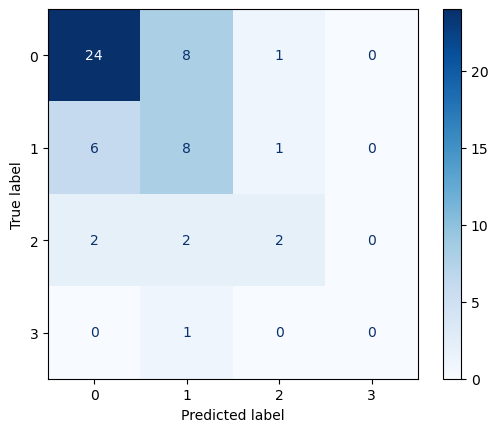

In [44]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test, cmap='Blues')

In [45]:
#Vizualizing our tree to see which attributes were closes to root node
fig = plt.figure(figsize=(140,60))
clf_tree = tree.plot_tree(clf, 
                   feature_names=feature_cols,
                   fontsize=60,
                   filled=True)

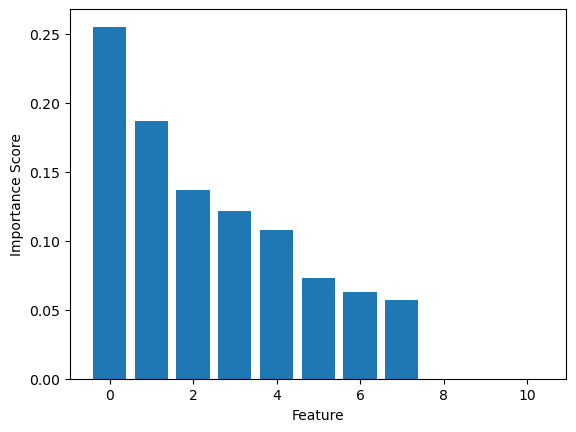

Feature 0 : career_PTS score:     0.2550 

Feature 1 : career_WS score:     0.1864 

Feature 2 : career_eFG% score:     0.1367 

Feature 3 : career_TRB score:     0.1216 

Feature 4 : career_PER score:     0.1077 

Feature 5 : career_FT% score:     0.0728 

Feature 6 : TotalPRA score:     0.0625 

Feature 7 : career_FG3% score:     0.0572 

Feature 8 : career_AST score:     0.0000 

Feature 9 : career_FG% score:     0.0000 

Feature 10 : draft_year score:     0.0000 



In [46]:
#Most important variables 
importance = clf.feature_importances_

dtc_bar = pd.DataFrame(importance, [x for x in range(len(importance))])
dtc_bar = dtc_bar.T
dtc_bar.columns = feature_cols
dtc_bar = dtc_bar.T
dtc_bar = dtc_bar.sort_values(by=0, ascending = False)

height = dtc_bar[0]
bars = dtc_bar.index
x_pos = np.arange(len(bars))

plt.bar(x_pos, height)
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.show()

x = dtc_bar.index
y = []
for i in x:
    y.append(i)

for i in range(len(dtc_bar[0])):
    k = dtc_bar[0][i]
    print('Feature',i,':', y[i],'score:',"{:10.4f}".format(k),'\n')
#plot feature importance


## Linear Regression

In [47]:
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

In [48]:
X = df_nba[['career_AST','career_FG3%','career_FT%',
           'career_PER','career_TRB','career_eFG%','TotalPRA',
            'career_WS','career_eFG%']]

y = df_nba['Salary_band']

In [49]:
#Select the 5 best estimators out of our 10 attributes
lr = linear_model.LinearRegression()
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=5)

In [50]:
print(sorted(zip(map(lambda x: x, rfe.ranking_), X.columns)))

[(1, 'TotalPRA'), (1, 'career_AST'), (1, 'career_PER'), (1, 'career_TRB'), (1, 'career_WS'), (2, 'career_eFG%'), (3, 'career_FT%'), (4, 'career_eFG%'), (5, 'career_FG3%')]


As we can see from above, our five best estimators are:
    1. Total Points Rebounds Assists
    2. Career Assists
    3. Career PER
    4. Career Rebounds 
    5. Career Win Share

As a reminder, our top 5 predictive variables from the DTC were:
    1. Career Assists
    2. Career FG %
    3. Career 3 PT %
    4. Career FT %
    5. Career PER


In [51]:
#Lets create a new model only using these top 5 attributes
X = df_nba[['TotalPRA','career_AST','career_PTS','career_TRB','career_WS']]
y = df_nba['Salary_band']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

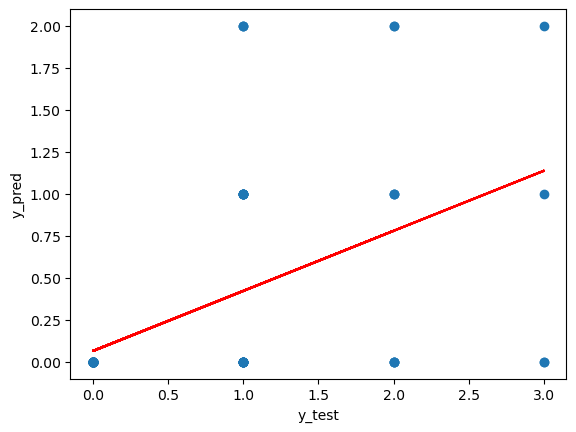

In [52]:
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.plot(y_test, p(y_test),'r--')

In [53]:
unique, counts = np.unique(y_test, return_counts = True)
print('Actual salary band in y_test with count:\n',np.asarray((unique, counts)).T)

Actual salary band in y_test with count:
 [[ 0 48]
 [ 1 22]
 [ 2  9]
 [ 3  4]]


In [54]:
unique, counts = np.unique(y_pred, return_counts = True)
print('Predicted salary band in y_pred with count:\n',np.asarray((unique, counts)).T)

Predicted salary band in y_pred with count:
 [[ 0 65]
 [ 1 12]
 [ 2  6]]


In [55]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Accuracy score for Logistic Regression', metrics.accuracy_score(y_test, y_pred), '\n')

print('Precision score:', precision_score(y_test, y_pred, average=None), '\n')

print('Recall score:', recall_score(y_test, y_pred, average=None), '\n')

print('f1 score:', f1_score(y_test, y_pred, average=None), '\n')

Accuracy score for Logistic Regression 0.6987951807228916 

Precision score: [0.73846154 0.66666667 0.33333333 0.        ] 

Recall score: [1.         0.36363636 0.22222222 0.        ] 

f1 score: [0.84955752 0.47058824 0.26666667 0.        ] 



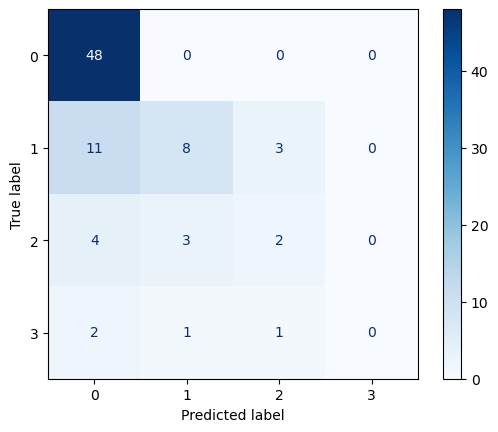

In [56]:
plot_confusion_matrix(lr, X_test, y_test, cmap='Blues')

In [57]:
importance

array([0.2550153 , 0.        , 0.        , 0.05722659, 0.0728005 ,
       0.10773611, 0.12162725, 0.18639613, 0.13673202, 0.        ,
       0.06246609])

Feature 0 : TotalPRA 
 score: [-0.09955348 -0.07802554 -0.02152794  0.05534759 -0.08224808] 

Feature 1 : career_AST 
 score: [ 0.03115392  0.10698664 -0.07583271  0.24473586 -0.06214758] 

Feature 2 : career_PTS 
 score: [ 0.08280953 -0.02182652  0.10463605  0.14648721 -0.0117777 ] 

Feature 3 : career_TRB 
 score: [-0.01440997 -0.00713458 -0.0072754  -0.44657066  0.15617335] 



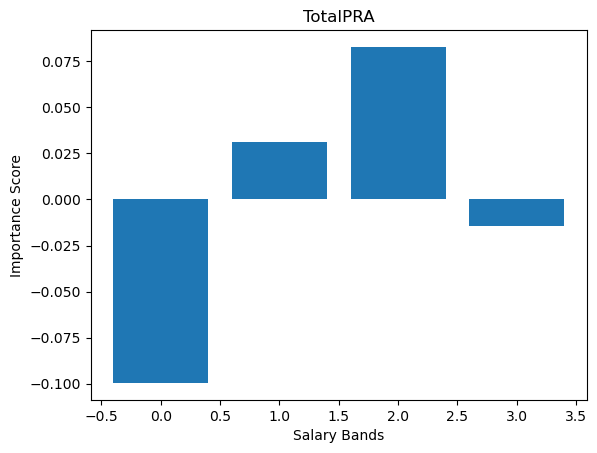

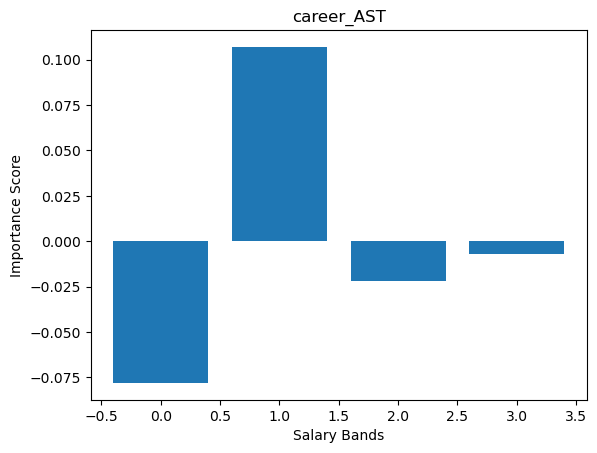

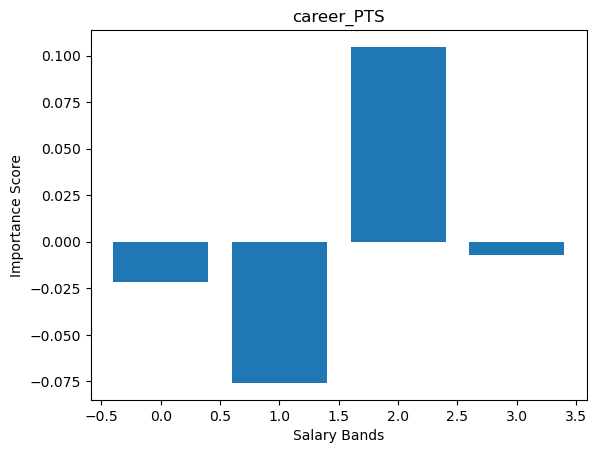

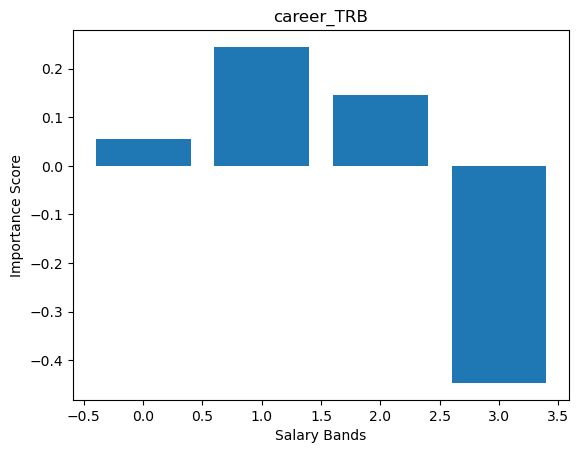

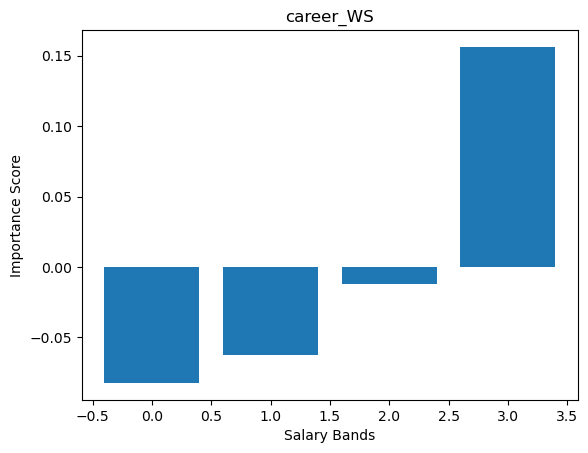

In [58]:
importance = lr.coef_
importance = importance.T
# summarize feature importance
for i,v in enumerate(importance.T):
    print('Feature', i,':', X.columns[i], '\n score:', v, '\n')
#plot feature importance

plot1 = plt.figure(1)
ax1 = plt.bar([x for x in range(len(importance[0]))], importance[0])
plt.title(X.columns[0])
plt.ylabel('Importance Score')
plt.xlabel('Salary Bands')

plot2 = plt.figure(2)
ax2 = plt.bar([x for x in range(len(importance[1]))], importance[1])
plt.title(X.columns[1])
plt.ylabel('Importance Score')
plt.xlabel('Salary Bands')

plot3 = plt.figure(3)
ax3 = plt.bar([x for x in range(len(importance[2]))], importance[2])
plt.title(X.columns[2])
plt.ylabel('Importance Score')
plt.xlabel('Salary Bands')

plot4 = plt.figure(4)
ax4 = plt.bar([x for x in range(len(importance[3]))], importance[3])
plt.title(X.columns[3])
plt.ylabel('Importance Score')
plt.xlabel('Salary Bands')

plot5 = plt.figure(5)
ax5 = plt.bar([x for x in range(len(importance[4]))], importance[4])
plt.title(X.columns[4])
plt.ylabel('Importance Score')
plt.xlabel('Salary Bands')

plt.show()

## Conclusion

By inspecting the Decision Tree and Logistic Regression, we can identify the most important variables. In order, between the two, we can see that career Points in the most important variable, with career Win Share being the next most important. Attributes like Rebounds and Assists helped predict low salary but not high salary. 

Although I would not have anticipated Win Share to have such a high importance score, it is not surprising that NBA Presidents want to keep their team together if that team is winning, and over pay a player to keep the team synergy together. 

The Decision Tree focused on efficiency scores, such as shooting percentage and PER, while logistic regression had more success predicting the salary band with individual performance such as Points, Assists, and Win Share. 